# COVID-19 Predictors by State
This notebook explores 23 predictors that could be useful for analyzing the COVID19 pandemic. The predictors are described in detail in the dataset's description.  

Whereas there has been much research into COVID19 as it affects nation states, this dataset focuses on individual states in the US, including the District of Columbia. The purpose of this notebook is to analyze the predictors themselves, not to create analytical models. This is due to the fact that COVID19 numbers (tests, infections, deaths) are updated constantly; thus, current models are preliminary and are trying to hit a moving target.

In [137]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import RobustScaler

pd.set_option('display.max_columns', None)

In [138]:
df = pd.read_csv('./COVID19_state.csv')
df.head()

,State,Tested,Infected,Deaths,Population,Pop Density,Gini,ICU Beds,Income,GDP,Unemployment,Sex Ratio,Smoking Rate,Flu Deaths,Respiratory Deaths,Physicians,Hospitals,Health Spending,Pollution,Med-Large Airports,Temperature,Urban,Age 0-25,Age 26-54,Age 55+,School Closure Date
0,Alaska,3713,119,3.0,734002,1.2863,0.4081,119,59687,73205,5.8,1.054688,21.0,12.1,35.3,1900,21,11064,6.4,1.0,26.6,66.0,0.36,0.39,0.25,03/19/20
1,Alabama,6531,947,6.0,4908621,96.9221,0.4847,1533,42334,45219,2.7,0.930145,20.9,21.4,58.0,12205,101,7281,8.1,1.0,62.8,59.0,0.33,0.37,0.31,03/16/20
2,Arkansas,6028,508,7.0,3038999,58.4030,0.4719,732,42566,42454,3.5,0.956630,22.3,18.0,61.7,7150,88,7408,7.1,0.0,60.4,56.2,0.34,0.37,0.30,03/17/20
3,Arizona,16759,1157,20.0,7378494,64.9550,0.4713,1559,43650,48055,4.5,0.966965,15.6,12.4,41.2,17806,83,6452,9.7,1.0,60.3,89.8,0.33,0.36,0.30,03/16/20
4,California,89600,5763,135.0,39937489,256.3727,0.4899,7338,62586,74205,3.9,0.975113,11.3,15.6,30.9,112906,359,7549,12.8,9.0,59.4,95.0,0.33,0.40,0.26,03/19/20


## Statistical Distributions
Kernel Density Estimation and Histogram for numerical predictors across all 50 states and DC

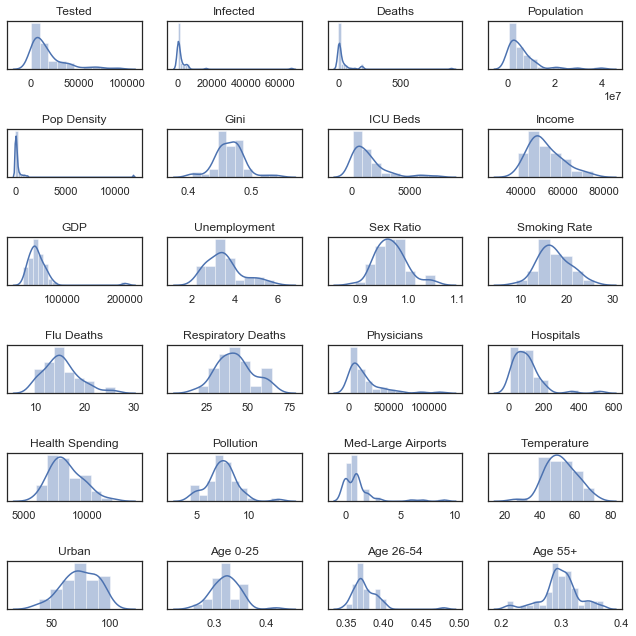

In [139]:
NUM_ROWS = 6
NUM_COLS = 4

cols_of_interest = df[df.columns[1:-1]]
col_names = cols_of_interest.columns

f, axes = plt.subplots(6, 4, figsize=(9, 9), sharex=False)
c = 0
for i in range(NUM_ROWS):
    for j in range(NUM_COLS):
        g = sns.distplot(cols_of_interest[col_names[c]], ax=axes[i, j], axlabel=False)
        g.tick_params(left=False, bottom=False)
        g.set(yticklabels=[])
        g.set_title(col_names[c], fontsize=12)
        c += 1
f.tight_layout()

### QQ Plots of Selected Factors
The distribution of some factors looks to be normal while others are exponential. QQ plots can be used to confirm these assumptions and provide a different perspective on a factor's distribution.

The following QQ plots fit an exponential distribution to the Infected column.

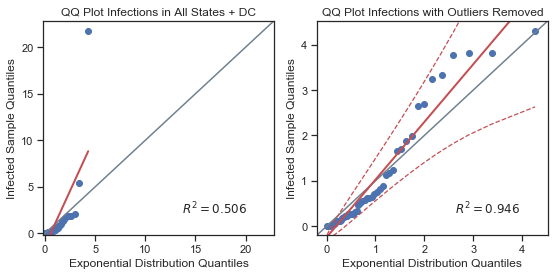

In [140]:
fig, ax = plt.subplots(ncols=2, figsize=(8,4))
pg.qqplot(df['Infected'], dist='expon', ax=ax[0], confidence=False)
ax[0].set_title('QQ Plot Infections in All States + DC')

df_no_ol = df[(df.State != 'New York') & (df.State != 'New Jersey')]

pg.qqplot(df_no_ol['Infected'], dist='expon', ax=ax[1])
ax[1].set_title('QQ Plot Infections with Outliers Removed')
[ax[i].set_xlabel('Exponential Distribution Quantiles') for i in range(0,len(ax))]
[ax[i].set_ylabel('Infected Sample Quantiles') for i in range(0,len(ax))]
fig.tight_layout()

Note how in the first QQ plot there are 2 major outliers from the data, further inspection showed that these were from New York and New Jersey. The outliers were removed and the second plot fits the exponential distribution nicely.

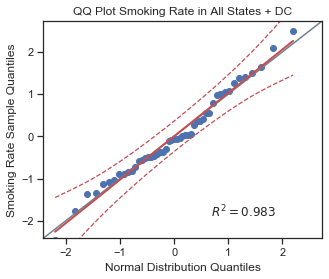

In [141]:
ax = pg.qqplot(df_no_ol['Smoking Rate'], dist='norm')
ax.set_xlabel('Normal Distribution Quantiles')
ax.set_ylabel('Smoking Rate Sample Quantiles')
ax.set_title('QQ Plot Smoking Rate in All States + DC')
plt.show()

The Smoking Rate column follows a normal distribution.

## Outliers in COVID19 Numbers
It is vitally important to call out the imbalance of the COVID19 metrics (Infected, Tested and Deaths). These numbers are being constantly updated and the virus is still rather new in United States, comparatively speaking.

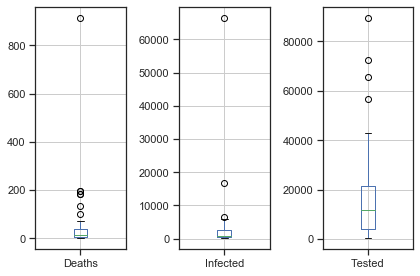

In [142]:
f, ax = plt.subplots(1, 3)
df['Deaths'].plot.box(grid='True', ax=ax[0])
df['Infected'].plot.box(grid='True', ax=ax[1])
df['Tested'].plot.box(grid='True', ax=ax[2])
f.tight_layout()

As shown above, each of the COVID19 metrics has a good deal of outliers. This should be taken into context when creating and interpreting models. These boxplots should expand as more data comes is made available and results are standardized.

## Correlations and Feature Reduction
Correlations of each numerical column including COVID19 tests, infections and deaths

In [143]:
def make_corr_map(df, title='Correlation Heat Map', size=(9,7)):
    corr = df.corr()
    mask = np.triu(np.ones_like(corr)) # for upper triangle
    f, ax = plt.subplots(figsize=size)
    cmap = sns.diverging_palette(240, 10, as_cmap=True)
    sns.heatmap(corr, mask=mask, cmap=cmap, square=True, linewidths=.5, cbar_kws={"shrink": .5})
    plt.title(title)

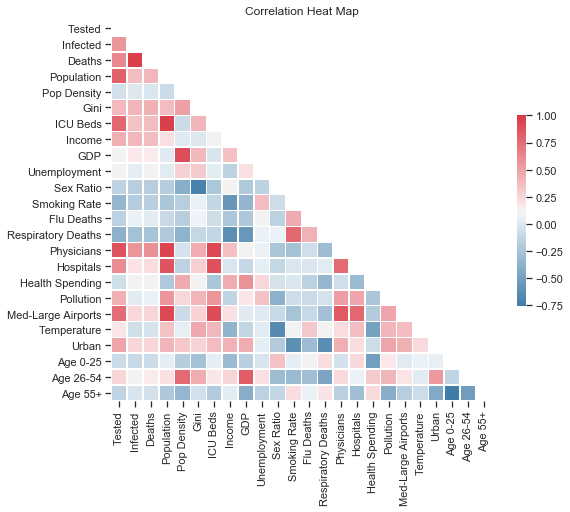

In [144]:
make_corr_map(df)

As shown in the heat map above, some predictors are highly correlated with others. For example, Population is highly positively correlated with Physicians, Hospitals, Med-Lar Airports and ICU beds.  

### Model-based Feature Reduction
Just as a quick heuristic, a random forest regressor can be used to get an idea of feature importances.

#### Random Forest Regressor

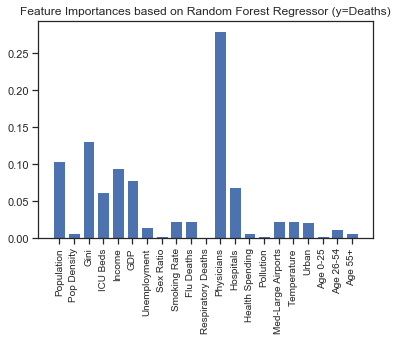

In [145]:
X = df[df.columns[4:-1]]
X_s = RobustScaler().fit_transform(X) # scale the data
rfr = RandomForestRegressor(max_depth=10).fit(X_s, df['Deaths'])
plt.bar(X.columns, rfr.feature_importances_)
plt.xticks(fontsize=10, rotation=90)
plt.title('Feature Importances based on Random Forest Regressor (y=Deaths)')
plt.show()

This result is definitely not expected! The next cell digs deeper into why Physicians may be an important feature.

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


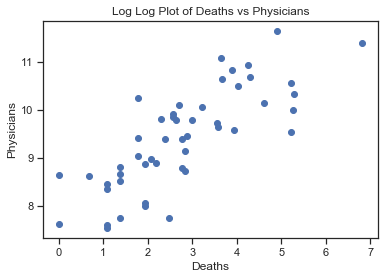

In [146]:
plt.scatter(np.log(df['Deaths']), np.log(df['Physicians']))
plt.xlabel('Deaths')
plt.ylabel('Physicians')
plt.title('Log Log Plot of Deaths vs Physicians')
plt.show()

The log log plot shows a clear trend. This shows that there exists a relationship y=X<sup>n</sup>.  

Looking back the heat map above, Physicians is also highly correlated with Hospitals and Med-Large Airports. According to US news articles about COVID19, the virus was transmitted from abroad and likely entered the US through airports. International airports with high throughput are also indicative of larger cities, where the virus spreads faster. Effectively, Physicians could be a proxy for other highly correlated variables relating to larger cities, where the virus is more pronounced. 

In this situation, the heuristic of using a random forest regressor to judge feature importances did not work out well. However, feature reduction still needs to occur. The next portion of the notebook demonstrates a reduction of features through qualitative reasoning.

## Grouping the Predictors
Another way to reduce the number of features is to qualitatively group them into categories. The predictors in this dataset could mostly be grouped into **Socioeconomic** and **Public Health** categories, with some overlap between the two. Furthermore, predictors such as Med-Large Airports and Temperature do not fit into the above categories, but would nevertheless be interesting to see in analytical models.

In [147]:
socio = ['Population', 'Pop Density', 'Gini', 'Income', 'GDP', 'Unemployment', 'Sex Ratio',
         'Health Spending', 'Urban', 'Age 0-25', 'Age 26-54', 'Age 55+']
health = ['ICU Beds', 'Smoking Rate', 'Flu Deaths', 'Respiratory Deaths', 'Physicians', 'Hospitals', 
          'Health Spending', 'Pollution', 'Age 0-25', 'Age 26-54', 'Age 55+', 'Tested']

df_socio, df_health = df[socio], df[health]

### Correlations Revisited

#### Socioeconomic Predictors

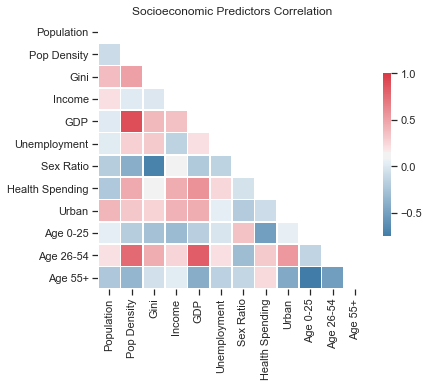

In [148]:
make_corr_map(df_socio, 'Socioeconomic Predictors Correlation', (6,6))

It is clear from the above heat map that GDP is highly correlated with other factors such as Pop Density, and Gini is highly correlated with Sex Ratio. As a rule of thumb, highly correlated features should be removed.

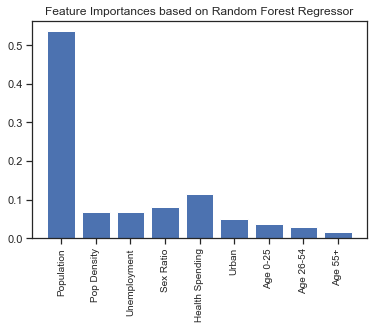

In [149]:
X = df_socio.drop(['GDP', 'Gini', 'Income'], axis=1)
X_s = RobustScaler().fit_transform(X) # scale the data
rfr = RandomForestRegressor().fit(X_s, df['Deaths'])
plt.bar(X.columns, rfr.feature_importances_)
plt.xticks(fontsize=10, rotation=90)
plt.title('Feature Importances based on Random Forest Regressor')
plt.show()

Qualitatively, this result make sense, population should be a good predictor of deaths. The next cell takes a closer look at the relationship between Population and Deaths.

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


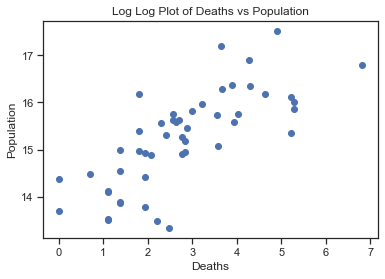

In [150]:
plt.scatter(np.log(df['Deaths']), np.log(df['Population']))
plt.xlabel('Deaths')
plt.ylabel('Population')
plt.title('Log Log Plot of Deaths vs Population')
plt.show()

Note that if one were to plot these variables without the log scale, outliers would clearly be shown on the Deaths axis. In this case, New York has many more deaths than other states, causing it to be an outlier. However, as COVID19 numbers continue to be reported, these models should adjust accordingly.

#### Public Health Predictors

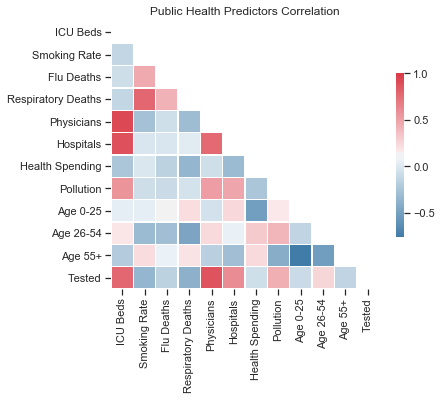

In [151]:
make_corr_map(df_health, 'Public Health Predictors Correlation', (6,6))

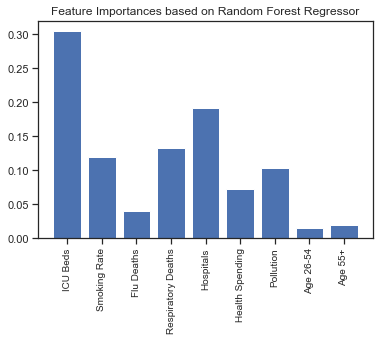

In [152]:
X = df_health.drop(['Age 0-25', 'Physicians', 'Tested'], axis=1)
X_s = RobustScaler().fit_transform(X) # scale the data
rfr = RandomForestRegressor().fit(X_s, df['Deaths'])
plt.bar(X.columns, rfr.feature_importances_)
plt.xticks(fontsize=10, rotation=90)
plt.title('Feature Importances based on Random Forest Regressor')
plt.show()

In this case, ICU Beds could be a proxy metric for large urban centers. The heat map at the top of the Correlations and Feature Reduction section shows that ICU Beds is highly correlated with Physicians, Hospitals and Med-Large Airports. Knowing that New York City is the hardest hit area, this result makes sense. However, note again that New York is an outlier in the Deaths column. As more COVID19 data comes in, these models will likely change.

## The School Closures Predictor
School Closures is the sole categorical predictor in the dataset. The following plot shows this data in (hopefully!) readable format.

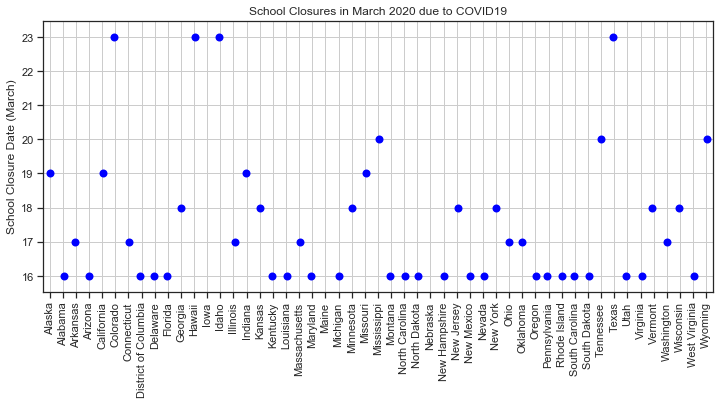

In [189]:
df['School Closure Date'] = pd.to_datetime(df['School Closure Date'])
df['Date Encoding'] = df['School Closure Date'].dt.day

fig, ax = plt.subplots(figsize=(12,5))
g = sns.stripplot(x='State', y='Date Encoding', data=df, ax=ax, color='blue', size=8);
ax.set_title('School Closures in March 2020 due to COVID19')
ax.set_xticklabels(labels=df['State'], rotation=90)
ax.set_ylabel('School Closure Date (March)')
ax.set_xlabel('')
plt.grid()
plt.show()